---

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import configparser
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from collections import Counter

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']
input_dir = vg_json_export + 'models/frequency_affected_perceptron/'

colors = preprocessing.basic_colors()

classifier_list = ['perceptron']

set_type = 'test'

# Diagramme etc als Graustufen anzeigen. Verwendung: greyscale(labels), ergibt Liste von Farbwerten
greyscale = lambda x: plt.cm.gray(np.linspace(0.2,0.8,len(x)))

### Prediction-Arrays importieren

In [2]:
# Gezippte Numpy-Archive importieren
perceptron_arrays = np.load(input_dir+'results_freq_aff_perceptron_bgr.npz')
# Prediction-Arrays aus importierten Numpy-Dateien
perceptron_predict = perceptron_arrays['predict_'+set_type+'_y']
# IDs zu Perceptron-Prediction-Array hinzufügen
ids = perceptron_arrays[set_type+'_y'][:,0:1]
perceptron_predict = np.append(ids, perceptron_predict, axis=1)

In [3]:
perceptron_predict = pd.DataFrame(perceptron_predict).sort_values(by=0).to_numpy()
print (perceptron_predict.shape)

(8536, 12)


### DataFrames importieren + filtern, DataFrames für CDOs/CBOs/CNOs erstellen

In [4]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
test_obj = pd.read_csv(vg_json_export+"extracted_data/"+set_type+"_df.csv", index_col=0)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
# test_obj auf frequente Objekte reduzieren
freq_obj = all_obj.loc[perceptron_predict[:,0]]
# DataFrames für CDOs, CBOs und CNOs
cd_obj = freq_obj.loc[freq_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = freq_obj.loc[freq_obj.object_name.isin(color_biased_objects)]
#cb_obj = freq_obj.loc[np.logical_not(freq_obj.object_name.isin(list(color_diagnostic_objects.keys())+color_neutral_objects))]
cn_obj = freq_obj.loc[freq_obj.object_name.isin(color_neutral_objects)]

print ('Anzahl Einträge in DataFrames:',dict(zip(('freq_obj','cd_obj','cb_obj','cn_obj'),(len(freq_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))
freq_obj, cd_obj, cn_obj, cb_obj = [df.loc[df.index.isin(ids.ravel())] for df in [freq_obj, cd_obj, cn_obj, cb_obj]]
print ('Anzahl Einträge in reduzierten DataFrames:', dict(zip(('freq_obj','cd_obj','cb_obj','cn_obj'),(len(freq_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))

# Überprüfen, ob prediction-Arrays gleich viele Einträge haben wie freq_obj
print ('Identische Indizes für Prediction-Arrays und DataFrame:', perceptron_predict[:,0:1].ravel().astype(int).tolist() == freq_obj.index.tolist())

/home/simeon/Dokumente/Masterarbeit/environments/ma_env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Anzahl Einträge in DataFrames: {'freq_obj': 8536, 'cd_obj': 1052, 'cb_obj': 1053, 'cn_obj': 1537}
Anzahl Einträge in reduzierten DataFrames: {'freq_obj': 8536, 'cd_obj': 1052, 'cb_obj': 1053, 'cn_obj': 1537}
Identische Indizes für Prediction-Arrays und DataFrame: True


## Predictions und Test-DF zusammenführen
Resultat: Ein DF pro Bedingung (alle Objekte, CDO, CBO, CNO)

In [5]:
# DataFrames aus Predictions (np-Arrays) erstellen
perceptron_predict_df =  pd.DataFrame(data=perceptron_predict[0:,1:],index=perceptron_predict[0:,0],columns=colors)
# Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
pred_label_perceptron = perceptron_predict_df.idxmax(axis=1)
# Predictions mit freq_obj kombinieren
predict_df = freq_obj.copy()
predict_df['perceptron_color'] = pred_label_perceptron
# DFs für CDOs, CNOs und CBOs
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cbo = predict_df.loc[cb_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

predict_df.head()

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id object_name  \
339.0     37    13   449   234    blue        19       5441        tape   
1016.0   102    67   149   272  purple        71    1062114       pants   
1131.0   314    82     0     4  yellow        84    1534345        wall   
1340.0    29    58   105   410  purple       104    1062282       strip   
1601.0    34    23     3   342    pink       137    1062396       shirt   

       perceptron_color  
339.0             white  
1016.0            white  
1131.0            white  
1340.0            white  
1601.0              red

## Objekte mit widersprüchlichen Farbattributen entfernen

# Informationen zu Train- und Test/Dev-Sets

### Train

BottomUp-Classifier:

Train-Items: 643691
Items pro Klasse: {'white': 183769, 'red': 65047, 'black': 112413, 'yellow': 37020, 'green': 63586, 'pink': 12136, 'blue': 72559, 'brown': 53346, 'orange': 17987, 'gray': 19429, 'purple': 6399}


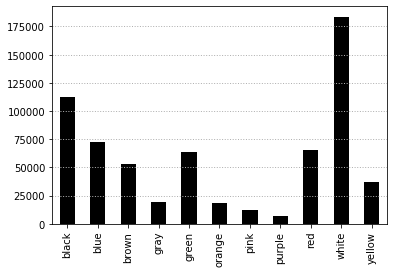

In [6]:
print ('BottomUp-Classifier:\n')

train_perceptron_arrays = np.load(vg_json_export+'feature_arrays/'+'/baseline_arrays_bgr_filtered.npz')
train_items = train_perceptron_arrays['train_y'][:,1:].argmax(axis=1)

# np.Series aus Train-Set
train_df = pd.DataFrame(data=np.eye(11)[train_items],index=train_perceptron_arrays['train_y'][:,0],columns=colors)
train_label = train_df.idxmax(axis=1)

print ('Train-Items: {items}\nItems pro Klasse: {classes}'
       .format(items=len(train_items),classes=dict(Counter(train_label)))
      )

# plotten
pd.Series(dict(Counter(train_label))).sort_index().plot.bar(cmap='gray')
plt.gca().yaxis.grid(linestyle=':', linewidth=1)
# als png speichern
plt.savefig(vg_json_export+'images/'+'unsampled_train_color_distribution.png',bbox_inches="tight")
plt.show()

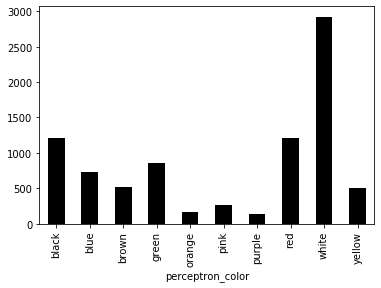

In [7]:
predict_df.groupby('perceptron_color').size().plot.bar(cmap='gray')

### Test/Dev

Ganzes Test-set:

Items insgesamt: 8536
Items pro Klasse:{'blue': 776, 'purple': 776, 'yellow': 776, 'pink': 776, 'green': 776, 'gray': 776, 'black': 776, 'white': 776, 'orange': 776, 'brown': 776, 'red': 776}


cdo:
##########

Items : 1052
Durchschnitt Items/Klasse: 95.64
Items pro Klasse: {'blue': 202, 'green': 363, 'purple': 26, 'brown': 46, 'pink': 14, 'white': 127, 'gray': 95, 'black': 44, 'yellow': 35, 'orange': 70, 'red': 30}
Anteil Item an Gesamtmenge: [('green', 0.345), ('blue', 0.192), ('white', 0.121), ('gray', 0.09), ('orange', 0.067), ('brown', 0.044), ('black', 0.042), ('yellow', 0.033), ('red', 0.029), ('purple', 0.025), ('pink', 0.013)]


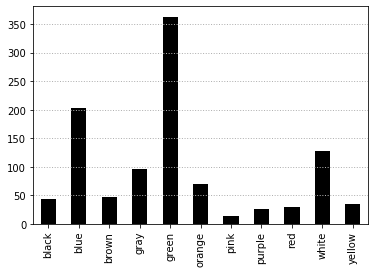

cbo:
##########

Items : 1053
Durchschnitt Items/Klasse: 95.73
Items pro Klasse: {'purple': 79, 'red': 92, 'green': 47, 'gray': 97, 'blue': 80, 'brown': 126, 'orange': 92, 'black': 145, 'pink': 85, 'white': 124, 'yellow': 86}
Anteil Item an Gesamtmenge: [('black', 0.138), ('brown', 0.12), ('white', 0.118), ('gray', 0.092), ('orange', 0.087), ('red', 0.087), ('yellow', 0.082), ('pink', 0.081), ('blue', 0.076), ('purple', 0.075), ('green', 0.045)]


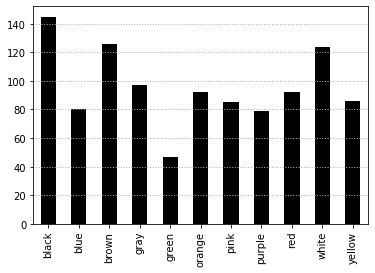

cno:
##########

Items : 1537
Durchschnitt Items/Klasse: 139.73
Items pro Klasse: {'pink': 223, 'gray': 147, 'green': 79, 'red': 157, 'orange': 143, 'white': 77, 'brown': 80, 'yellow': 120, 'blue': 154, 'purple': 255, 'black': 102}
Anteil Item an Gesamtmenge: [('purple', 0.166), ('pink', 0.145), ('red', 0.102), ('blue', 0.1), ('gray', 0.096), ('orange', 0.093), ('yellow', 0.078), ('black', 0.066), ('brown', 0.052), ('green', 0.051), ('white', 0.05)]


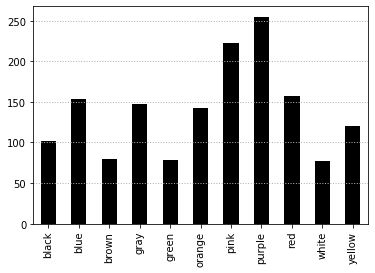

All:
##########



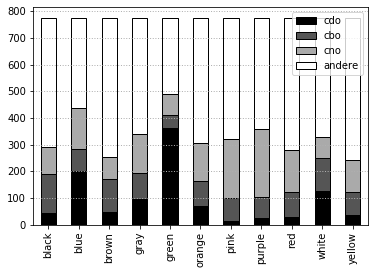

In [8]:
print ('Ganzes {}-set:\n'.format(set_type.capitalize()))

testdev_items = predict_df['color'].to_numpy()
total_items = len(predict_df)
total_items_per_class = Counter(testdev_items)
print ('Items insgesamt: {items}\nItems pro Klasse:{classes}\n\n'.format(
    items= total_items,
    classes = dict(total_items_per_class)
))

color_counts = dict()

for cl in 'cdo cbo cno'.split():
    print (cl+':\n'+'#'*10+'\n')
    
    testdev_items = eval("predict_"+cl+"['color'].to_numpy()")
    total_items = sum(Counter(testdev_items).values())
    items_per_class = Counter(testdev_items)
    total_items_per_class = total_items_per_class - items_per_class
    print ('Items : {items}\nDurchschnitt Items/Klasse: {average}\nItems pro Klasse: {classes}\nAnteil Item an Gesamtmenge: {percentage}'.format(
        items=total_items,
        average=round(total_items/len(items_per_class), 2),
        classes = dict(items_per_class),
        percentage = sorted(
            set(zip(
                list(items_per_class), 
                np.round(np.array(list(items_per_class.values()))/total_items, decimals=3))), 
            key=lambda elem:elem[1], reverse=True)
    ))
    
    # Verteilung Farbwörter plotten
    pd.Series(dict(Counter(testdev_items))).sort_index().plot.bar(cmap='gray')
    plt.gca().yaxis.grid(linestyle=':', linewidth=1)
    # als png speichern
    plt.savefig(vg_json_export+'images/'+'bottomup_vergleich_color_distribution_'+cl+'.png',bbox_inches="tight")
    plt.show()
    
    color_counts.update({cl:dict(Counter(testdev_items))})
    
print ('All:\n'+'#'*10+'\n')
# Unspezifizierte Objekte hinzufügen
color_counts.update({'andere':dict(Counter(total_items_per_class))})
# Verteilung Farbwörter plotten
pd.DataFrame(color_counts).plot.bar(stacked=True, colormap='gray', edgecolor='black')
plt.gca().yaxis.grid(linestyle=':', linewidth=1)
# als png speichern
plt.savefig(vg_json_export+'images/'+'bottomup_vergleich_color_distribution_all.png',bbox_inches="tight")
plt.show()

# Ergebnisse überprüfen

In [9]:
accuracy_scores = {} 
print ('Accuracy')
for classifier in classifier_list:
    accuracy_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='accuracy'))
# accuracy_scores als LaTeX-Tabelle:
#print (pd.DataFrame(accuracy_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=2).to_latex())

f1_scores = {} 
print ('f1')
for classifier in classifier_list:
    f1_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='f1', average='macro'))
# f1_scores als LaTeX-Tabelle:
#print (pd.DataFrame(f1_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=2).to_latex())

Accuracy
perceptron:
Metric: accuracy
{'Alle Objekte': 0.3581302717900656}
{'Color-Diagnostic Objects': 0.48954372623574144}
{'Color-Biased Objects': 0.32573599240265905}
{'Color-Neutral Objects': 0.35393623942745606}


f1
perceptron:
Metric: f1
{'Alle Objekte': 0.3396041844276405}
{'Color-Diagnostic Objects': 0.3723677845676598}
{'Color-Biased Objects': 0.2811934724396105}
{'Color-Neutral Objects': 0.3418400945618344}




/home/simeon/Dokumente/Masterarbeit/environments/ma_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Alle Objekte

In [10]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_df['color'], predict_df[classifier+'_color']))
    report = pd.DataFrame(classification_report(predict_df['color'], predict_df[classifier+'_color'], output_dict=True))\
        .drop(['support'], axis=0).drop(['weighted avg', 'accuracy'], axis=1)\
        .T[['precision', 'recall', 'f1-score']].round(decimals=2)
    # LaTeX
    # print (report.to_latex())

perceptron


/home/simeon/Dokumente/Masterarbeit/environments/ma_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       black       0.33      0.51      0.40       776
        blue       0.48      0.45      0.47       776
       brown       0.39      0.26      0.31       776
        gray       0.00      0.00      0.00       776
       green       0.50      0.55      0.52       776
      orange       0.76      0.16      0.27       776
        pink       0.64      0.22      0.33       776
      purple       0.85      0.15      0.25       776
         red       0.37      0.58      0.45       776
       white       0.18      0.68      0.29       776
      yellow       0.58      0.38      0.46       776

    accuracy                           0.36      8536
   macro avg       0.46      0.36      0.34      8536
weighted avg       0.46      0.36      0.34      8536



In [11]:
perceptron_report = pd.DataFrame(classification_report(predict_df['color'], predict_df['perceptron'+'_color'], output_dict=True))[colors].T
perceptron_report['prec-rec-diff'] = perceptron_report.apply(lambda x: x.precision - x.recall, axis=1)
perceptron_report['prec-rec-diff_abs'] = perceptron_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

In [12]:
perceptron_report.sort_values(by='f1-score')

f1-score  precision    recall  support  prec-rec-diff  \
gray    0.000000   0.000000  0.000000    776.0       0.000000   
purple  0.250549   0.850746  0.146907    776.0       0.703839   
orange  0.267516   0.759036  0.162371    776.0       0.596665   
white   0.285483   0.180636  0.680412    776.0      -0.499776   
brown   0.308050   0.385659  0.256443    776.0       0.129216   
pink    0.327900   0.640449  0.220361    776.0       0.420089   
black   0.397391   0.325390  0.510309    776.0      -0.184919   
red     0.454819   0.372533  0.583763    776.0      -0.211230   
yellow  0.457588   0.577603  0.378866    776.0       0.198737   
blue    0.465517   0.479508  0.452320    776.0       0.027189   
green   0.520833   0.496495  0.547680    776.0      -0.051185   

        prec-rec-diff_abs  
gray             0.000000  
purple           0.703839  
orange           0.596665  
white            0.499776  
brown            0.129216  
pink             0.420089  
black            0.184919  
red              0.211230  
yellow           0.198737  
blue             0.027189  
green            0.051185

In [13]:
perceptron_report.describe()

f1-score  precision     recall  support  prec-rec-diff  \
count  11.000000  11.000000  11.000000     11.0      11.000000   
mean    0.339604   0.460732   0.358130    776.0       0.102602   
std     0.145517   0.247214   0.215332      0.0       0.360585   
min     0.000000   0.000000   0.000000    776.0      -0.499776   
25%     0.276499   0.348962   0.191366    776.0      -0.118052   
50%     0.327900   0.479508   0.378866    776.0       0.027189   
75%     0.456203   0.609026   0.528995    776.0       0.309413   
max     0.520833   0.850746   0.680412    776.0       0.703839   

       prec-rec-diff_abs  
count          11.000000  
mean            0.274804  
std             0.241935  
min             0.000000  
25%             0.090200  
50%             0.198737  
75%             0.459932  
max             0.703839

## Mean Reciprocal Rank

In [14]:
# Werte von 0 bis 1, bester Wert 1
for classifier in classifier_list:
    print (classifier)
    print (round(
        evaluation.get_label_ranking_average_precision_score(pd.get_dummies(predict_df.color), eval(classifier+'_predict_df')),2
    ))
    print ('\n')

perceptron
0.54




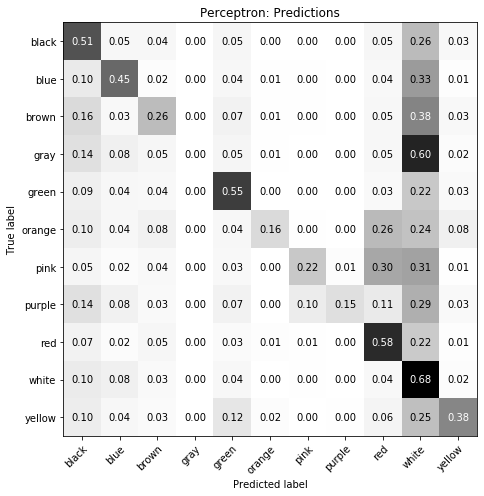

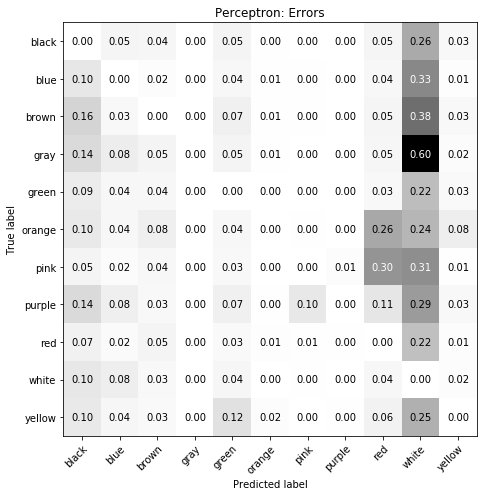

In [15]:
df = predict_df

for classifier in classifier_list:
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + ': Predictions', error_matrix=False, cmap=plt.cm.Greys, colorbar=False, save_image=True, file_dir = vg_json_export+'images/')
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + ': Errors', error_matrix=True, cmap=plt.cm.Greys, colorbar=False, save_image=True, file_dir = vg_json_export+'images/')